<a href="https://colab.research.google.com/github/ShubhamHooda01/Data-Science-Projects/blob/main/Bike_sharing_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
#!pip install prophet

In [ ]:
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet

# Get the data

In [ ]:
# we are not using index in this model
data = pd.read_csv('/content/Daily Bike Sharing.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
# Selecting usefull variables
dataset = data.loc[:,["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.sample(2)

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
72,2011-03-14,2046,0,1,1,0.325217,0.332000,0.496957,0.136926
109,2011-04-20,3944,0,1,1,0.595000,0.564392,0.614167,0.241925


# Data Transformation

In [ ]:
# Date Variable
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = '%Y-%m-%d')
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [ ]:
#Renaming variables
dataset = dataset.rename(columns = {'cnt':'y', 'dteday':'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


# Holidays

In [ ]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday':'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [ ]:
#removing holiday column from dataset
dataset = dataset.drop('holiday', axis = 1)
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


# Training and Test set

In [ ]:
test_days = 31
training_data = dataset.iloc[:-test_days,:]
test_data = dataset.iloc[-test_days:,:]
len(dataset),len(training_data),len(test_data)

(731, 700, 31)

# Model

In [ ]:
# Facebook Prophet
model = Prophet(growth = 'linear',
                yearly_seasonality= True,
                weekly_seasonality= True,
                daily_seasonality= False,
                holidays = holidays,
                seasonality_mode= 'multiplicative',
                seasonality_prior_scale= 10,
                holidays_prior_scale= 10,
                changepoint_prior_scale= .05)

In [ ]:
# Add regressor
reg_list = ["workingday", "weathersit","temp", "atemp", "hum", "windspeed"]
for reg in reg_list:
  model.add_regressor(reg)

In [ ]:
# Fit the model
model.fit(training_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/ayav38he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/qjy0d2ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31254', 'data', 'file=/tmp/tmpwb0risjc/ayav38he.json', 'init=/tmp/tmpwb0risjc/qjy0d2ig.json', 'output', 'file=/tmp/tmpwb0risjc/prophet_modelymo4d4h8/prophet_model-20240114085140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:51:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:51:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Forecasting

In [ ]:
# Create future dataframe
future = model.make_future_dataframe(periods = test_days,
                                     freq = 'D')
future.tail(1)

,ds
730,2012-12-31


In [ ]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]], axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [ ]:
#forecast
forecast = model.predict(future)
len(forecast)

731

In [ ]:
#predictions
prediction_prophet = forecast.yhat[-test_days:].rename("Prophet")
prediction_prophet.head()

700    4167.824722
701    3511.074034
702    5700.237804
703    5704.246700
704    5405.673519
Name: Prophet, dtype: float64

# Visualisation

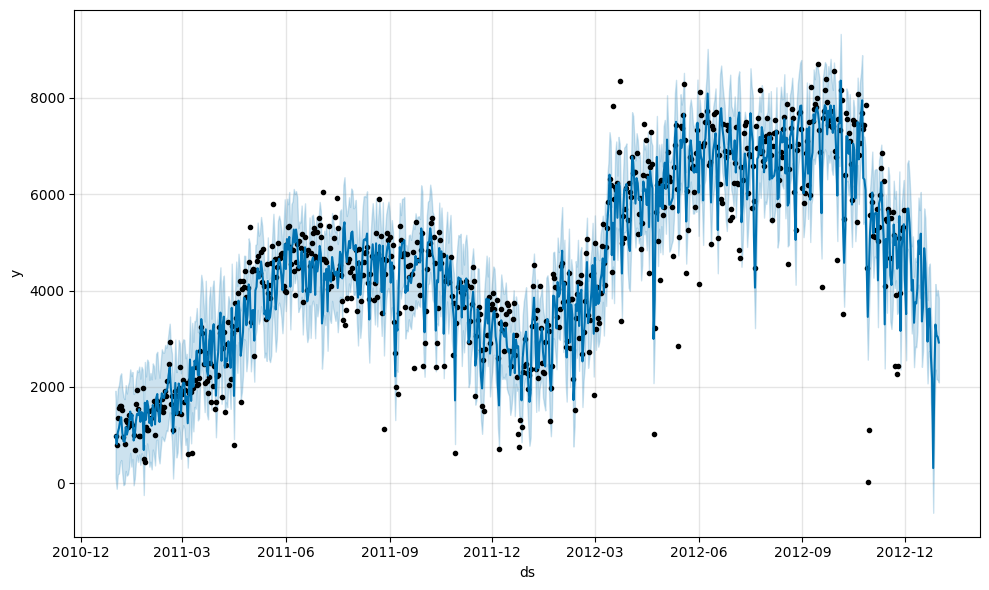

In [ ]:
model.plot(forecast);

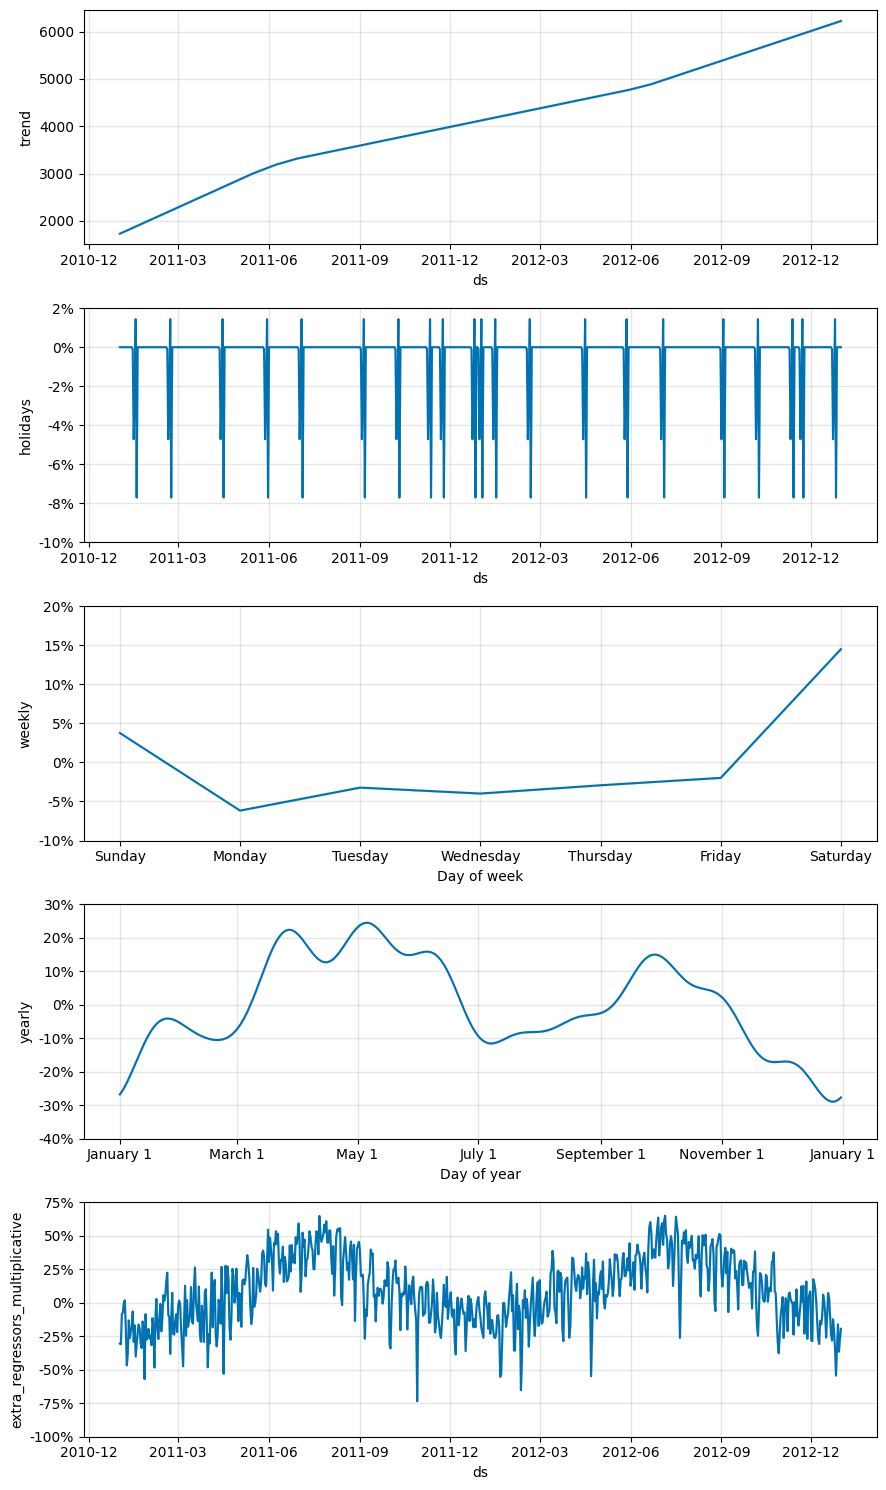

In [ ]:
#plot components
model.plot_components(forecast);

# Model Assessment

In [ ]:
#MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolutr Error: ',round(mean_absolute_error(test_data['y'], prediction_prophet),2))

print('Root Mean Squared Error: ',round(np.sqrt(mean_squared_error(test_data['y'], prediction_prophet)), 2))

Mean Absolutr Error:  859.38
Root Mean Squared Error:  1027.02


In [ ]:
#MAPE Function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean((np.abs((y_true - y_pred)/ y_true))) * 100

print('MAPE: ',round(MAPE(test_data['y'], prediction_prophet),2),'%')

MAPE:  34.64 %


# Cross Validation

In [ ]:
#cross-section
from prophet.diagnostics import cross_validation

In [ ]:
df_cv = cross_validation(model,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = 'processes')
df_cv

INFO:prophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7b269fa34f40>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/8c23mcoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/if37zajf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/ia5mmbzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31596', 'data', 'file=/tmp/tmpwb0risjc/8c23mcoh.json', 'init=/tmp/tmpwb0risjc/ia5mmbzt.json', 'output', 'file=/tmp/tmpwb0risjc/prophet_modelc26nw1o1/prophet_model-20240114085730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/bktlh40m.json
DEBUG:cmdstanpy:idx 0
08:57:30 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:running

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8169.482992,7461.298534,8938.854995,5463,2012-06-28
1,2012-06-30,7241.577929,6404.294742,8020.649140,5687,2012-06-28
2,2012-07-01,7436.856165,6696.221400,8263.462749,5531,2012-06-28
3,2012-07-02,6770.381131,6042.095270,7504.241390,6227,2012-06-28
4,2012-07-03,7444.546153,6684.312044,8204.847402,6660,2012-06-28
...,...,...,...,...,...,...
274,2012-11-26,5918.112124,5092.227256,6837.047424,5087,2012-10-30
275,2012-11-27,3459.978075,2585.935969,4282.072557,3959,2012-10-30
276,2012-11-28,5311.201708,4422.838978,6168.617612,5260,2012-10-30
277,2012-11-29,5710.767324,4810.155603,6614.444179,5323,2012-10-30


In [ ]:
print('Mean Absolutr Error: ',round(mean_absolute_error(df_cv['y'], df_cv['yhat']),2))

print('Root Mean Squared Error: ',round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])), 2))

print('MAPE: ',round(MAPE(df_cv['y'], df_cv['yhat']),2),'%')

Mean Absolutr Error:  1015.9
Root Mean Squared Error:  1281.03
MAPE:  126.59 %


# Hyperparameter Tuning

In [ ]:
#parameter grid
from sklearn.model_selection import  ParameterGrid

In [ ]:
param_grid = {'seasonality_prior_scale': [5,10,20],
              'changepoint_prior_scale': [.01,.05,.1],
              'holidays_prior_scale': [5,10,20],}
param_grid

{'seasonality_prior_scale': [5, 10, 20],
 'changepoint_prior_scale': [0.01, 0.05, 0.1],
 'holidays_prior_scale': [5, 10, 20]}

In [ ]:
grid = ParameterGrid(param_grid)
list(grid)[:10]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 10,
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 20,
  'seasonality_prior_scale': 20},
 {'changepoint_prior_scale': 0.05,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5}]

In [ ]:
#Hyper parameter tuning
rsme = []
for params in grid:
  #Build model
  model = Prophet(growth = 'linear',
                yearly_seasonality= True,
                weekly_seasonality= True,
                daily_seasonality= False,
                holidays = holidays,
                seasonality_mode= 'multiplicative',
                seasonality_prior_scale= params['seasonality_prior_scale'],
                holidays_prior_scale= params['holidays_prior_scale'],
                changepoint_prior_scale= params['changepoint_prior_scale'])
  reg_list = ["workingday", "weathersit","temp", "atemp", "hum", "windspeed"]
  for reg in reg_list:
    model.add_regressor(reg)
  model.fit(training_data)
  #cross-validation
  df_cv = cross_validation(model,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = 'processes')
  #gather results
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rsme.append(error)




DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/mz8_9c33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/f64qwype.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10423', 'data', 'file=/tmp/tmpwb0risjc/mz8_9c33.json', 'init=/tmp/tmpwb0risjc/f64qwype.json', 'output', 'file=/tmp/tmpwb0risjc/prophet_modelirqzdh7c/prophet_model-20240114092406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:24:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:24:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7b26903ae770>
DEBUG:cmdstanpy:input tempfile: 

# Best parameters

In [ ]:
best_params = grid[np.argmin(rsme)]
print(f'Best params: {best_params}')

Best params: {'seasonality_prior_scale': 20, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.01}


# Final Prophet Model

In [ ]:
#Build model
model = Prophet(growth = 'linear',
              yearly_seasonality= True,
              weekly_seasonality= True,
              daily_seasonality= False,
              holidays = holidays,
              seasonality_mode= 'multiplicative',
              seasonality_prior_scale= best_params['seasonality_prior_scale'],
              holidays_prior_scale= best_params['holidays_prior_scale'],
              changepoint_prior_scale= best_params['changepoint_prior_scale'])
reg_list = ["workingday", "weathersit","temp", "atemp", "hum", "windspeed"]
for reg in reg_list:
  model.add_regressor(reg)
model.fit(training_data)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/y1hct8vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwb0risjc/5xgw3f4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53216', 'data', 'file=/tmp/tmpwb0risjc/y1hct8vu.json', 'init=/tmp/tmpwb0risjc/5xgw3f4z.json', 'output', 'file=/tmp/tmpwb0risjc/prophet_model9okkrg_r/prophet_model-20240114093251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Create future DataFrame
future = model.make_future_dataframe(periods = test_days,
                                     freq = 'D')
future.tail(1)

,ds
730,2012-12-31


In [ ]:
future = pd.concat([future, dataset.iloc[:,2:]], axis = 1)
future.tail(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,1,2,0.215833,0.223487,0.5775,0.154846


In [ ]:
#Forcast
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2473.085484,382.505187,2237.643573,2473.085484,2473.085484,-0.054823,-0.054823,-0.054823,-0.282580,...,0.000000,0.000000,0.000000,-0.258351,-0.258351,-0.258351,0.0,0.0,0.0,1274.269475
1,2011-01-02,2478.491231,71.306620,1984.341619,2478.491231,2478.491231,-0.059438,-0.059438,-0.059438,-0.291157,...,0.000000,0.000000,0.000000,-0.252078,-0.252078,-0.252078,0.0,0.0,0.0,1022.220554
2,2011-01-03,2483.896977,378.678903,2234.485255,2483.896977,2483.896977,-0.136141,-0.136141,-0.136141,-0.197050,...,0.029825,0.029825,0.029825,-0.244563,-0.244563,-0.244563,0.0,0.0,0.0,1323.461073
3,2011-01-04,2489.302724,471.967430,2304.215704,2489.302724,2489.302724,-0.125538,-0.125538,-0.125538,-0.186268,...,0.029825,0.029825,0.029825,-0.235919,-0.235919,-0.235919,0.0,0.0,0.0,1439.232270
4,2011-01-05,2494.708471,712.309846,2621.915353,2494.708471,2494.708471,-0.117534,-0.117534,-0.117534,-0.119637,...,0.029825,0.029825,0.029825,-0.226282,-0.226282,-0.226282,0.0,0.0,0.0,1620.125943


In [ ]:
#Extract predictions
prediction_prophet = forecast.yhat[-test_days:].rename('prophet')
prediction_prophet.head()

700    4113.408578
701    3480.743041
702    5619.069193
703    5608.555696
704    5306.707104
Name: prophet, dtype: float64

In [ ]:
prediction_prophet.index = test_data.ds
prediction_prophet.head()

ds
2012-12-01    4113.408578
2012-12-02    3480.743041
2012-12-03    5619.069193
2012-12-04    5608.555696
2012-12-05    5306.707104
Name: prophet, dtype: float64

In [ ]:
prediction_prophet.to_csv('prediction_prophet.csv', index = True)